In [132]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Reading

In [36]:
# Reading and fixing column names
df = (pd.read_csv('Sleep_health_and_lifestyle_dataset.csv', index_col=[0])
        .rename( columns=str.lower )
        .rename( columns=lambda x: x.replace(' ', '_') )
        )

df

,gender,age,occupation,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,bmi_category,blood_pressure,heart_rate,daily_steps,sleep_disorder
Person ID,,,,,,,,,,,,
1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,None
2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,None
4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...
370,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
371,Female,59,Nurse,8.0,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
372,Female,59,Nurse,8.1,9,75,3,Overweight,140/95,68,7000,Sleep Apnea


## Validating for each column content

In [3]:
df.isna().sum()

gender                     0
age                        0
occupation                 0
sleep_duration             0
quality_of_sleep           0
physical_activity_level    0
stress_level               0
bmi_category               0
blood_pressure             0
heart_rate                 0
daily_steps                0
sleep_disorder             0
dtype: int64

In [4]:
df.gender.value_counts(normalize=True)

Male      0.505348
Female    0.494652
Name: gender, dtype: float64

In [5]:
df.occupation.value_counts() # Some partition fields: medical | technical | humanities

Nurse                   73
Doctor                  71
Engineer                63
Lawyer                  47
Teacher                 40
Accountant              37
Salesperson             32
Software Engineer        4
Scientist                4
Sales Representative     2
Manager                  1
Name: occupation, dtype: int64

<Axes: >

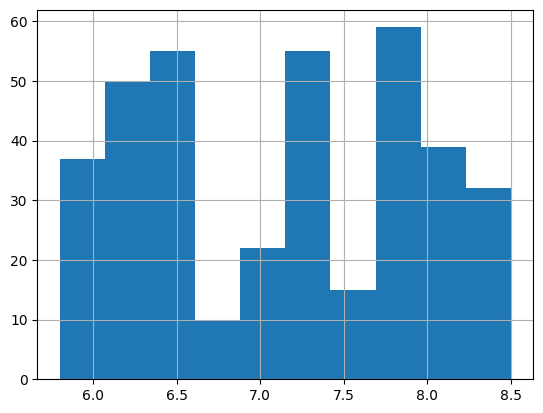

In [6]:
df.sleep_duration.hist()

<Axes: >

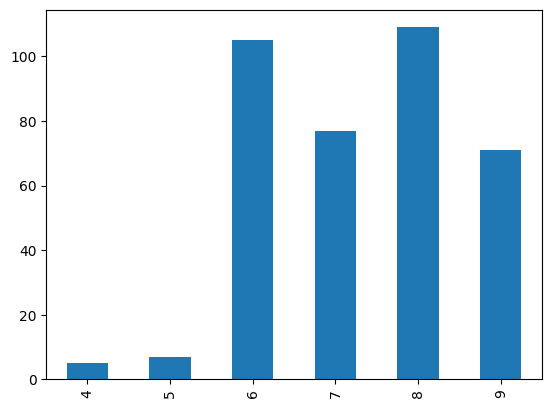

In [7]:
df.quality_of_sleep.value_counts().sort_index().plot.bar()

<Axes: >

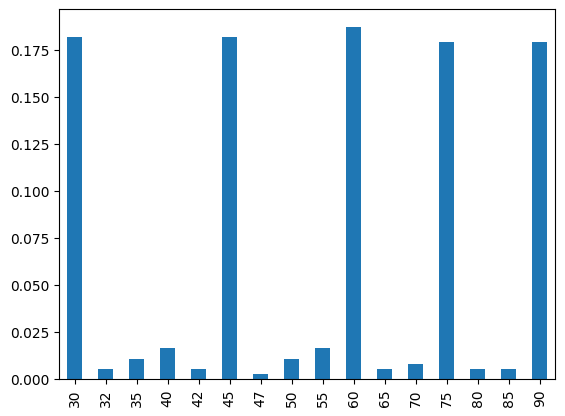

In [8]:
df.physical_activity_level.value_counts(normalize=True).sort_index().plot.bar() 

<Axes: >

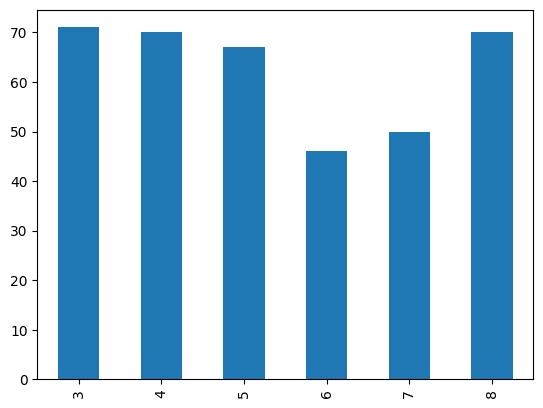

In [9]:
df.stress_level.value_counts().sort_index().plot.bar()

<Axes: >

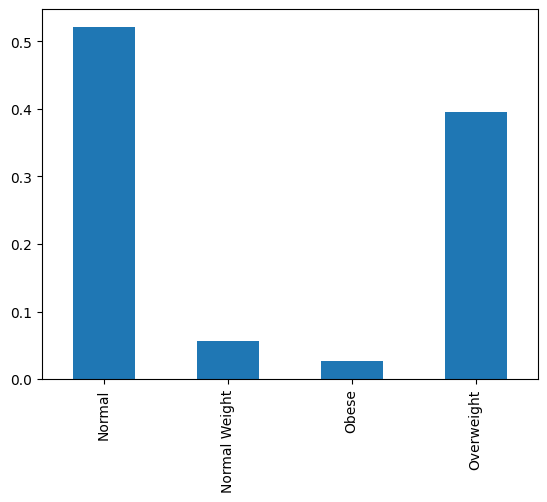

In [10]:
df.bmi_category.value_counts(normalize=True).sort_index().plot.bar()

In [11]:
df.daily_steps.value_counts()

8000     101
6000      68
5000      68
7000      66
10000     36
5500       4
3000       3
3500       3
4000       3
6800       3
4800       2
7300       2
7500       2
4200       2
3300       2
5600       2
5200       2
4100       2
3700       2
6200       1
Name: daily_steps, dtype: int64

<Axes: >

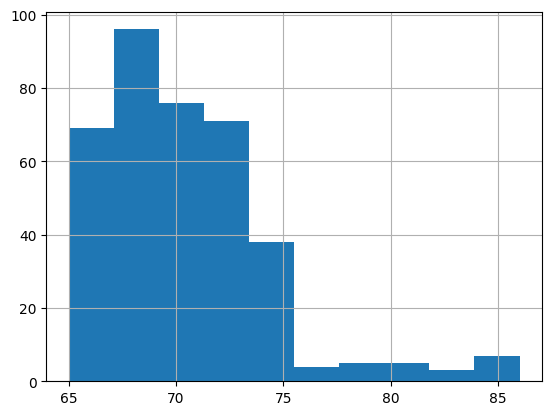

In [12]:
df.heart_rate.hist()

The first number (systolic) represents the pressure in your blood vessels when your heart beats. The second number (diastolic) represents the pressure in your vessels when your heart rests between beats. A normal blood pressure reading is typically around 120/80 mmHg

In [13]:
df.blood_pressure.value_counts()

130/85    99
140/95    65
125/80    65
120/80    45
115/75    32
135/90    27
140/90     4
125/82     4
132/87     3
128/85     3
126/83     2
115/78     2
139/91     2
142/92     2
119/77     2
135/88     2
129/84     2
128/84     2
131/86     2
117/76     2
130/86     2
118/75     2
121/79     1
122/80     1
118/76     1
Name: blood_pressure, dtype: int64

<Axes: >

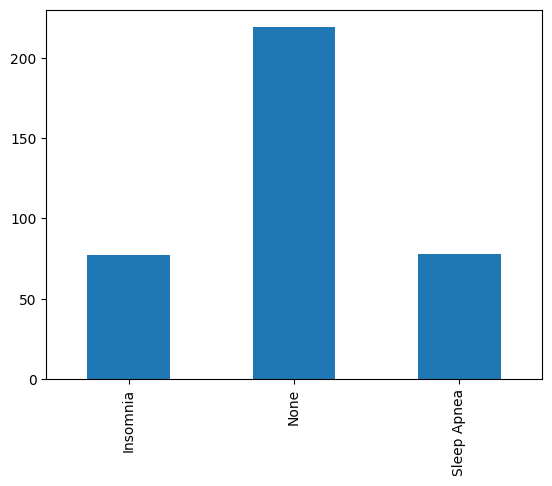

In [14]:
df.sleep_disorder.value_counts(normalize=False).sort_index().plot.bar()

# Building a Feature Selection Pipeline

In [17]:
from sklearn.preprocessing import OneHotEncoder

In [145]:
def cleaning1(df) -> pd.DataFrame:
    """
    First cleaning pipeline
    """

    occupations_mapping = {
        'Software Engineer': 'technical',
        'Doctor': 'medical',
        'Sales Representative': 'humanities',
        'Teacher': 'humanities',
        'Nurse': 'medical',
        'Engineer': 'technical',
        'Accountant': 'technical',
        'Scientist': 'technical',
        'Lawyer': 'humanities',
        'Salesperson': 'humanities',
        'Manager': 'humanities'
    }

    bmi_mapping = {
        'Overweight': 1,
        'Normal': 0,
        'Obese': 1,
        'Normal Weight': 0,
        }
    
    # Simplifying class
    cast_cat = {
        'None': 0,
        'Sleep Apnea': 1,
        'Insomnia' : 1
    }

    # Mapping acording to the above dictionaries
    clean_fr = (df
                    .join( pd.get_dummies(df['gender'], prefix='is', drop_first=True) )
                    .assign( # ADDING EXTRA COLUMNS USSING THE MAPPINGS ABOVE
                        work_field = df['occupation'].map(occupations_mapping),
                        elevated_bmi = df['bmi_category'].map(bmi_mapping).astype('uint8'),
                        systolic_hr = df['blood_pressure'].str.split('/', expand=True)[0].astype('int64'),
                        diastolic_hr = df['blood_pressure'].str.split('/', expand=True)[1].astype('int64'),
                        ) 
                    .pipe( 
                            lambda _df: 
                                (_df.join( pd.get_dummies(_df['work_field'], prefix='wf', drop_first=False) ) # SETTING WORKFIELD DUMMIES
                                    .assign( sleep_issue = _df['sleep_disorder'].astype(str).map(cast_cat) ) # Fixing target variable
                                    )
                          )
                    .drop(columns=['gender', 'occupation', 'bmi_category', 'blood_pressure', 'sleep_disorder', 'work_field'])
                    )
    
    return clean_fr

In [146]:
df1 = cleaning1(df)
df1.head()

,age,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,heart_rate,daily_steps,is_Male,elevated_bmi,systolic_hr,diastolic_hr,wf_humanities,wf_medical,wf_technical,sleep_issue
Person ID,,,,,,,,,,,,,,,
1,27,6.1,6,42,6,77,4200,1,1,126,83,0,0,1,0
2,28,6.2,6,60,8,75,10000,1,0,125,80,0,1,0,0
3,28,6.2,6,60,8,75,10000,1,0,125,80,0,1,0,0
4,28,5.9,4,30,8,85,3000,1,1,140,90,1,0,0,1
5,28,5.9,4,30,8,85,3000,1,1,140,90,1,0,0,1


<Axes: >

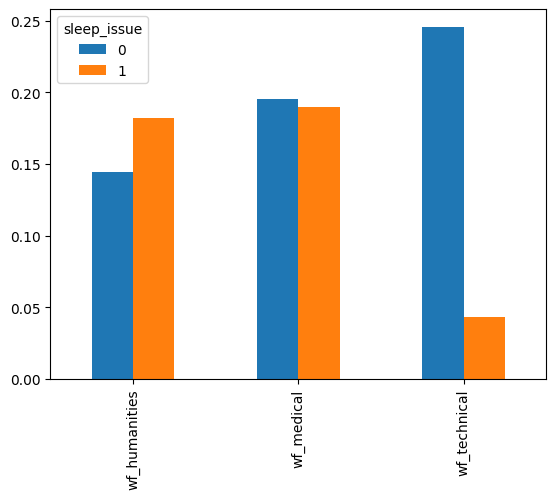

In [147]:
(df1.iloc[:, -4:]
    .groupby(by=['sleep_issue'])
    .sum()
    .T
    .div(len(df1))
    ).plot.bar()

In [137]:
df1.select_dtypes(include=['int', 'float']).corr().style.background_gradient(cmap='coolwarm')

,age,sleep_duration,quality_of_sleep,physical_activity_level,stress_level,heart_rate,daily_steps,systolic_hr,diastolic_hr,sleep_issue
age,1.000000,0.344709,0.473734,0.178993,-0.422344,-0.225606,0.057973,0.605878,0.593839,0.432007
sleep_duration,0.344709,1.000000,0.883213,0.212360,-0.811023,-0.516455,-0.039533,-0.180406,-0.166570,-0.338622
quality_of_sleep,0.473734,0.883213,1.000000,0.192896,-0.898752,-0.659865,0.016791,-0.121632,-0.110151,-0.310984
physical_activity_level,0.178993,0.212360,0.192896,1.000000,-0.034134,0.136971,0.772723,0.265416,0.382651,0.069787
stress_level,-0.422344,-0.811023,-0.898752,-0.034134,1.000000,0.670026,0.186829,0.102818,0.091811,0.181685
heart_rate,-0.225606,-0.516455,-0.659865,0.136971,0.670026,1.000000,-0.030309,0.294143,0.271092,0.330254
daily_steps,0.057973,-0.039533,0.016791,0.772723,0.186829,-0.030309,1.000000,0.103342,0.241986,-0.026575
systolic_hr,0.605878,-0.180406,-0.121632,0.265416,0.102818,0.294143,0.103342,1.000000,0.972885,0.692480
diastolic_hr,0.593839,-0.166570,-0.110151,0.382651,0.091811,0.271092,0.241986,0.972885,1.000000,0.705025
sleep_issue,0.432007,-0.338622,-0.310984,0.069787,0.181685,0.330254,-0.026575,0.692480,0.705025,1.000000


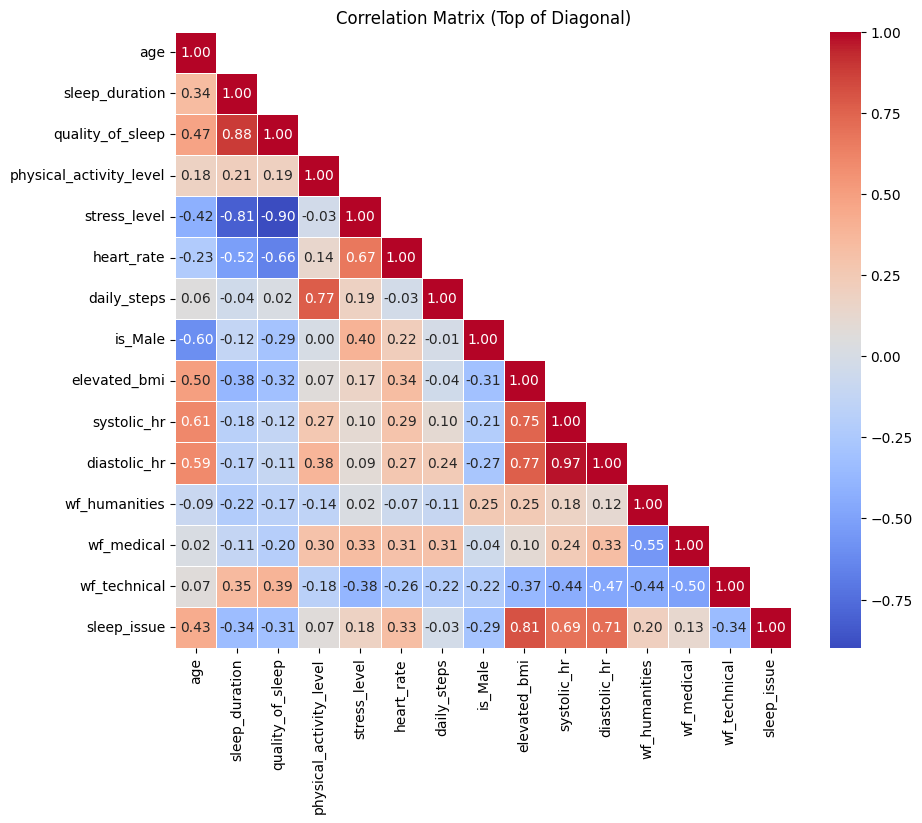

In [148]:
# Assuming you have the DataFrame 'df1' and you have calculated the correlation matrix
correlation_matrix = df1.corr(method='pearson') # pearson | kendall |spearman 

# Create the mask for the values at the top of the diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Create the heatmap for the values at the top of the diagonal
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            cmap='coolwarm',
            annot=True,
            fmt=".2f",
            mask=mask,
            square=True,
            linewidths=0.5)
plt.title("Correlation Matrix (Top of Diagonal)")
plt.show()


<Axes: >

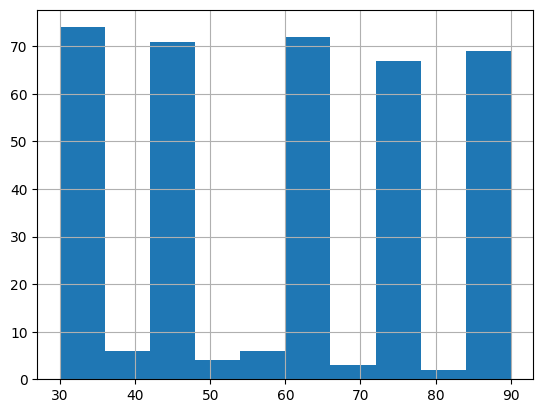

In [140]:
df1.physical_activity_level.hist()